In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 3.8MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 194kB 38.5MB/s 
     |████████████████████████████████| 1.2MB 31.4MB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# From Model to Production

## The Practice of Deep Learning

### Starting Your Project

## Gathering Data

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [4]:
import os


In [5]:
#search_images_ddg is the utility to download images from the internet
#It basically return a list containing url of the images.
def search_images_ddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term}, decode=False).decode()
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        try:
            data = urljson(requestUrl,data=params)
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(0.2)
    return L(urls)

In [6]:
results = search_images_ddg( 'grizzly bear', max_images=100)

type(results)


fastcore.foundation.L

In [12]:
#We can verify it via printing the list results

print(results)
len(results)

['https://www.naturalworldsafaris.com/~/media/images/blogs/2018/01/grizzly-bear-hunting-ban/mmr_2015-08-06_7055.jpg', 'https://detroitzoo.org/wp-content/uploads/2015/08/Grizzly-Boys.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f6/Ursus_arctos_californicus%2C_Santa_Barbara%2C_Natural_History_Museum.jpg/1200px-Ursus_arctos_californicus%2C_Santa_Barbara%2C_Natural_History_Museum.jpg', 'https://www.conservationnw.org/wp-content/uploads/2020/03/JSW_6993-scaled.jpg', 'http://www.wyofile.com/wp-content/uploads/2017/11/grizzly-pic-e1509641980482.jpg', 'https://i0.wp.com/www.commonsenseevaluation.com/wp-content/uploads/2013/08/Bear.jpg', 'https://s3.amazonaws.com/images.gearjunkie.com/uploads/2015/07/Grizzly-Bear.jpg', 'https://www.photos-public-domain.com/wp-content/uploads/2012/03/grizzly-bear.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/a9/GrizzlyBearJeanBeaufort.jpg/1200px-GrizzlyBearJeanBeaufort.jpg', 'https://gohunt-assets-us-west-2.s3.amazonaws.com/Grizz

100

In [13]:
#hide
ims = ['https://www.naturalworldsafaris.com/~/media/images/blogs/2018/01/grizzly-bear-hunting-ban/mmr_2015-08-06_7055.jpg']

In [15]:
# Created a images directory to put the downloaded pic
dest = 'images/grizzly.jpg'
download_url(ims[0], dest) # downloading the image to the given path

In [17]:
# PIL Image funtion is useful to visualise the downloaded pic
im = Image.open(dest)
im.to_thumb(228,228)

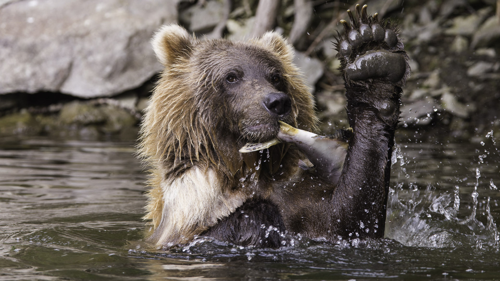

In [20]:
im.to_thumb( 500) # We can change number of pixel to visualize

In [21]:
# Lets create 3 diffrent directory for classes we are going to create in dataset
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [26]:
!ls

bears  gdrive  images  sample_data


In [29]:
!rm -rf  bears/

In [30]:
from tqdm import tqdm
if not path.exists():
    path.mkdir()
    for o in tqdm(bear_types):
        dest = (path/o)
        print(dest)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg( f'{o} bear', max_images=100)
        download_images(dest, urls=results) 

  0%|          | 0/3 [00:00<?, ?it/s]

bears/grizzly


 33%|███▎      | 1/3 [00:07<00:15,  7.98s/it]

bears/black


 67%|██████▋   | 2/3 [00:14<00:07,  7.58s/it]

bears/teddy


100%|██████████| 3/3 [00:45<00:00, 15.08s/it]


In [31]:
!ls 

bears  gdrive  images  sample_data


In [32]:
!ls bears/

black  grizzly	teddy


In [33]:
fns = get_image_files(path)
fns

(#254) [Path('bears/grizzly/00000023.jpg'),Path('bears/grizzly/00000099.jpg'),Path('bears/grizzly/00000085.jpg'),Path('bears/grizzly/00000064.jpg'),Path('bears/grizzly/00000038.jpg'),Path('bears/grizzly/00000092.jpg'),Path('bears/grizzly/00000057.jpg'),Path('bears/grizzly/00000082.jpg'),Path('bears/grizzly/00000051.jpg'),Path('bears/grizzly/00000061.jpg')...]

In [34]:
#There might be some corrupt images which we can verify 
failed = verify_images(fns)
failed

(#4) [Path('bears/teddy/00000081.jpg'),Path('bears/teddy/00000012.jpg'),Path('bears/black/00000061.png'),Path('bears/black/00000053.jpg')]

In [36]:
# After verifying we can unlink those images from the dataset we prepared
failed.map(Path.unlink);

FileNotFoundError: ignored

As I executed above cell twice so in last execution it failed as corrupt images have been deleted alreday

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

## From Data to DataLoaders

DataLoaders is a thin class that just stores whatever DataLoader objects you pass to it, and makes them available as train and valid. Although it's a very simple class, it's very important in fastai: it provides the data for your model. 

In [37]:

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [38]:
dls = bears.dataloaders(path)

In [41]:
dls.valid.show_batch(max_n=8, nrows=2)

In [42]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=1)

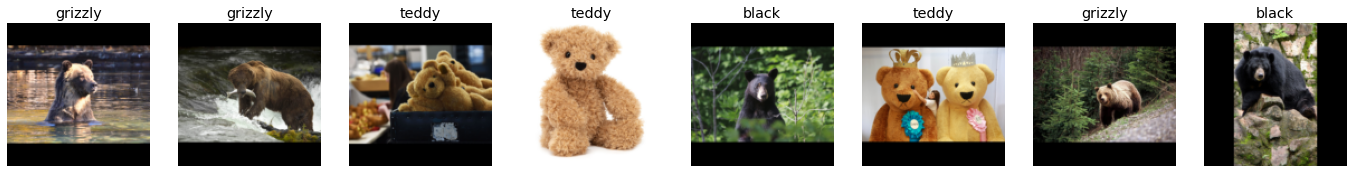

In [43]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=8, nrows=1)

In [44]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=1, unique=True)

### Data Augmentation

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


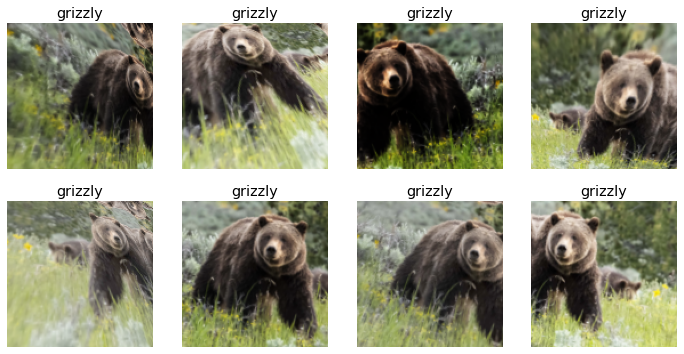

In [45]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [46]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [47]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


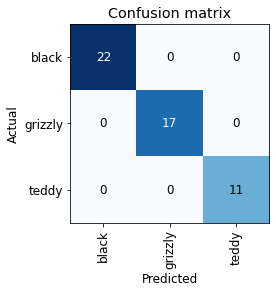

In [48]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

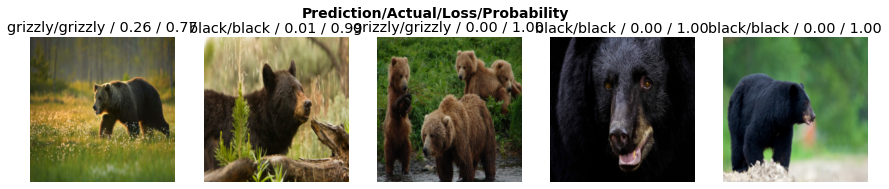

In [49]:
interp.plot_top_losses(5, nrows=1)

In [50]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [52]:
learn.export()

In [53]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [54]:
learn_inf = load_learner(path/'export.pkl')

In [55]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([1.0589e-05, 9.9998e-01, 5.5498e-06]))

In [56]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

### Creating a Notebook App from the Model

In [57]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [58]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [59]:
img = PILImage.create(btn_upload.data[-1])

In [60]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [61]:
pred,pred_idx,probs = learn_inf.predict(img)

In [62]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [63]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [64]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [65]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [66]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [67]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.6MB 4.0MB/s 
     |████████████████████████████████| 552kB 17.2MB/s 
     |████████████████████████████████| 122kB 19.5MB/s 
     |████████████████████████████████| 399kB 18.5MB/s 
     |████████████████████████████████| 81kB 8.1MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
ERROR: nbdev 1.1.14 has requirement nbconvert<6, but you'll have nbconvert 6.1.0 which is incompatible.
ERROR: jupyter-server 1.9.0 has requirement tornado>=6.1.0, but you'll have tornado 5.1.1 which is incompatible.
  Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
  Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5


Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?


### Deploying your app

## How to Avoid Disaster

### Unforeseen Consequences and Feedback Loops

## Get Writing!

## Questionnaire

1. Provide an example of where the bear classification model might work poorly in production, due to structural or style differences in the training data.
1. Where do text models currently have a major deficiency?
1. What are possible negative societal implications of text generation models?
1. In situations where a model might make mistakes, and those mistakes could be harmful, what is a good alternative to automating a process?
1. What kind of tabular data is deep learning particularly good at?
1. What's a key downside of directly using a deep learning model for recommendation systems?
1. What are the steps of the Drivetrain Approach?
1. How do the steps of the Drivetrain Approach map to a recommendation system?
1. Create an image recognition model using data you curate, and deploy it on the web.
1. What is `DataLoaders`?
1. What four things do we need to tell fastai to create `DataLoaders`?
1. What does the `splitter` parameter to `DataBlock` do?
1. How do we ensure a random split always gives the same validation set?
1. What letters are often used to signify the independent and dependent variables?
1. What's the difference between the crop, pad, and squish resize approaches? When might you choose one over the others?
1. What is data augmentation? Why is it needed?
1. What is the difference between `item_tfms` and `batch_tfms`?
1. What is a confusion matrix?
1. What does `export` save?
1. What is it called when we use a model for getting predictions, instead of training?
1. What are IPython widgets?
1. When might you want to use CPU for deployment? When might GPU be better?
1. What are the downsides of deploying your app to a server, instead of to a client (or edge) device such as a phone or PC?
1. What are three examples of problems that could occur when rolling out a bear warning system in practice?
1. What is "out-of-domain data"?
1. What is "domain shift"?
1. What are the three steps in the deployment process?

### Further Research

1. Consider how the Drivetrain Approach maps to a project or problem you're interested in.
1. When might it be best to avoid certain types of data augmentation?
1. For a project you're interested in applying deep learning to, consider the thought experiment "What would happen if it went really, really well?"
1. Start a blog, and write your first blog post. For instance, write about what you think deep learning might be useful for in a domain you're interested in.